# Bike Rides and the Poisson Model

To help the urban planners, you are called to model the daily bike rides in NYC using [this dataset](https://gist.github.com/sachinsdate/c17931a3f000492c1c42cf78bf4ce9fe/archive/7a5131d3f02575668b3c7e8c146b6a285acd2cd7.zip).  The dataset contains date, day of the week, high and low temp, precipitation and bike ride counts as columns. 



In [1]:
!wget https://gist.github.com/sachinsdate/c17931a3f000492c1c42cf78bf4ce9fe/archive/7a5131d3f02575668b3c7e8c146b6a285acd2cd7.zip
!unzip 7a5131d3f02575668b3c7e8c146b6a285acd2cd7.zip

--2023-02-26 21:10:52--  https://gist.github.com/sachinsdate/c17931a3f000492c1c42cf78bf4ce9fe/archive/7a5131d3f02575668b3c7e8c146b6a285acd2cd7.zip
Resolving gist.github.com (gist.github.com)... 192.30.255.112
Connecting to gist.github.com (gist.github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/gist/c17931a3f000492c1c42cf78bf4ce9fe/zip/7a5131d3f02575668b3c7e8c146b6a285acd2cd7 [following]
--2023-02-26 21:10:53--  https://codeload.github.com/gist/c17931a3f000492c1c42cf78bf4ce9fe/zip/7a5131d3f02575668b3c7e8c146b6a285acd2cd7
Resolving codeload.github.com (codeload.github.com)... 192.30.255.120
Connecting to codeload.github.com (codeload.github.com)|192.30.255.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘7a5131d3f02575668b3c7e8c146b6a285acd2cd7.zip’

7a5131d3f02575668b3     [ <=>                ]   2.56K  --.-KB/s    in 0s      

2023-

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(0)
sns.set_theme(style='whitegrid', palette='pastel')

import warnings
warnings.filterwarnings('ignore')

In [3]:
filename = "c17931a3f000492c1c42cf78bf4ce9fe-7a5131d3f02575668b3c7e8c146b6a285acd2cd7/nyc_bb_bicyclist_counts.csv"

df = pd.read_csv(filename)
df.head()

,Date,HIGH_T,LOW_T,PRECIP,BB_COUNT
0,1-Apr-17,46.0,37.0,0.00,606
1,2-Apr-17,62.1,41.0,0.00,2021
2,3-Apr-17,63.0,50.0,0.03,2470
3,4-Apr-17,51.1,46.0,1.18,723
4,5-Apr-17,63.0,46.0,0.00,2807


## Maximum Likelihood I 
 
The obvious choice in distributions is the [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution) which depends only on one parameter, λ, which is the average number of occurrences per interval. We want to estimate this parameter using Maximum Likelihood Estimation.

Implement a Gradient Descent algorithm from scratch that will estimate the Poisson distribution according to the Maximum Likelihood criterion. Plot the estimated mean vs iterations to showcase convergence towards the true mean. 

References: 

1. [This blog post](https://towardsdatascience.com/the-poisson-process-everything-you-need-to-know-322aa0ab9e9a). 

2. [This blog post](https://towardsdatascience.com/understanding-maximum-likelihood-estimation-fa495a03017a) and note the negative  log likelihood function.  


Negative log likelihood function for Poisson distribution

$n \lambda + \sum_{i=1}^n ln(x_i!) - ln(\lambda) \sum_{i=1}^n x_i$

Derivative of negative log likelihood in respect to lambda

$n - {1 \over \lambda} \sum_{i=1}^n x_i$

In [18]:
def gradient(l, x):
  n = len(x)
  lambda_gradient = n - (1 / l) * np.sum(x)
  return lambda_gradient

def gradient_descent(x, l, learning_rate, max_iter):
  lam = l
  lams = [] # keeping track of updated lambda
  for _ in range(max_iter):
    g = gradient(lam, x)

    lams.append(lam)
    lam = lam - learning_rate * g
  return lam, lams

In [39]:
cyclists = np.array(df['BB_COUNT'])
iterations = 100000
alpha = 0.001
lam = 1

estimated, lams = gradient_descent(cyclists, lam, alpha, iterations)

actual = (1 / len(cyclists)) * np.sum(cyclists)

print(f"Estimated mean={estimated}")
print(f"Actual mean={actual}")

Estimated mean=2679.715270113102
Actual mean=2680.042056074766


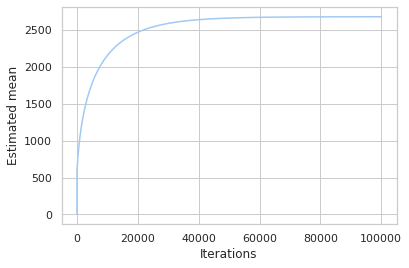

In [38]:
sns.lineplot(x=range(len(lams)), y=lams)
plt.xlabel('Iterations')
plt.ylabel('Estimated mean')
plt.show()

## Maximum Likelihood II

A colleague of yours suggest that the parameter $\lambda$ must be itself dependent on the weather and other factors since people bike when its not raining. Assume that you model $\lambda$ as 

$$\lambda_i = \exp(\mathbf w^T \mathbf x_i)$$

where $\mathbf x_i$ is one of the example features and $\mathbf w$ is a set of parameters. 

Train the model with SGD with this assumption and compare the MSE of the predictions with the `Maximum Likelihood I` approach. 

You may want to use [this partial derivative of the log likelihood function](http://home.cc.umanitoba.ca/~godwinrt/7010/poissonregression.pdf)

${\partial l \over \partial \beta} = \sum_{i=1}^n(y_i - exp(X'_i\beta)X_i$

In [157]:
def s_gradient(x, y, w):
  y_est = np.exp(np.dot(x, w))
  res = (y - y_est) * x.T

  r = []
  for i in range(len(res)):
    r.append(res[i][0])
  return np.array(r)

def s_gradient_descent(learning_rate, max_iter):
  w = np.array([0.0 for _ in range(4)])
  batch_size = 0.2

  for _ in range(max_iter):
    samples = df.sample(frac=batch_size)
    n = len(samples)

    x = np.hstack([
        np.array([1 for _ in range(n)]).reshape(n, 1),
        np.array(samples['HIGH_T']).reshape(n, 1),
        np.array(samples['LOW_T']).reshape(n, 1),
        np.array(samples['PRECIP']).reshape(n, 1)
    ])
    y = np.array(samples['BB_COUNT'])
    g = s_gradient(x, y, w)
    w = w - learning_rate * g

  return w

In [167]:
iterations = 10
alpha = 0.0001
lam = 1000

w = s_gradient_descent(alpha, iterations)
# print(w)

n = len(df)
x = np.hstack([
    np.array([1 for _ in range(n)]).reshape(n, 1),
    np.array(df['HIGH_T']).reshape(n, 1),
    np.array(df['LOW_T']).reshape(n, 1),
    np.array(df['PRECIP']).reshape(n, 1)
])
l = np.exp(w * x.T)
print(l)


ValueError: ignored